In [1]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQUxdDranxoePBzkT-bMJzme73alRjMUOz6vzz61lQ6bG0XVlpTsJZxY710si3vQGcoNTs7eXSxzhKg/pub?gid=0&single=true&output=csv'

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(url)
print(df.head())

                Date   Open   High    Low  Close    Volume
0  4/1/2015 16:00:00  40.60  40.76  40.31  40.72  36865322
1  4/2/2015 16:00:00  40.66  40.74  40.12  40.29  37487476
2  4/6/2015 16:00:00  40.34  41.78  40.18  41.55  39223692
3  4/7/2015 16:00:00  41.61  41.91  41.31  41.53  28809375
4  4/8/2015 16:00:00  41.48  41.69  41.04  41.42  24753438


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB
None
              Open         High          Low        Close        Volume
count  1511.000000  1511.000000  1511.000000  1511.000000  1.511000e+03
mean    107.385976   108.437472   106.294533   107.422091  3.019863e+07
std      56.691333    57.382276    55.977155    56.702299  1.425266e+07
min      40.340000    40.740000    39.720000    40.290000  1.016120e+05
25%      57.860000    58.060000    57.420000    57.855000  2.136213e+07
50%      93.990000    95.100000    92.920000    93.860000  2.662962e+07
75%     139.440000   140.3

we are going to predict closing price


<AxesSubplot:xlabel='Date'>

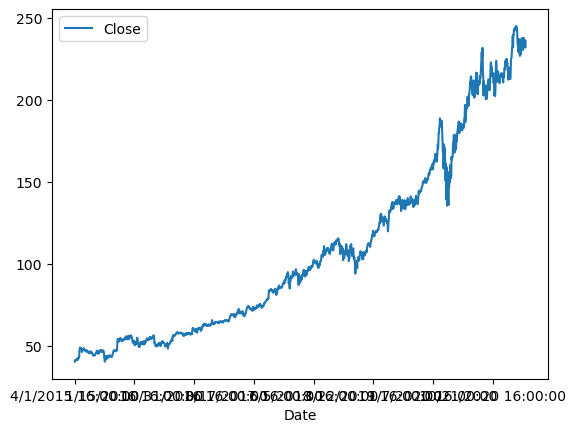

In [5]:
df.plot(x = 'Date', y = "Close")

In [6]:
from statsmodels.base.transform import BoxCox

In [7]:
bc = BoxCox()
df['Close'], lmbda = bc.transform_boxcox(df['Close'])

In [8]:
data = df[['Date' , 'Close']]
data.columns = ['ds' , 'y']

lets create a dictionary of parameter values

In [9]:
model_params = {
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "seasonality_mode": "multiplicative",
    "growth": "logistic"
}

In [15]:
from prophet import Prophet

In [16]:
model = Prophet(**model_params)
data['cap'] = data['y'].max() + data['y'].std() * 0.05


In [17]:
model.fit(data)

future = model.make_future_dataframe(periods=365)
future['cap'] = data['cap'].max()

forecast = model.predict(future)

23:27:48 - cmdstanpy - INFO - Chain [1] start processing
23:27:50 - cmdstanpy - INFO - Chain [1] done processing


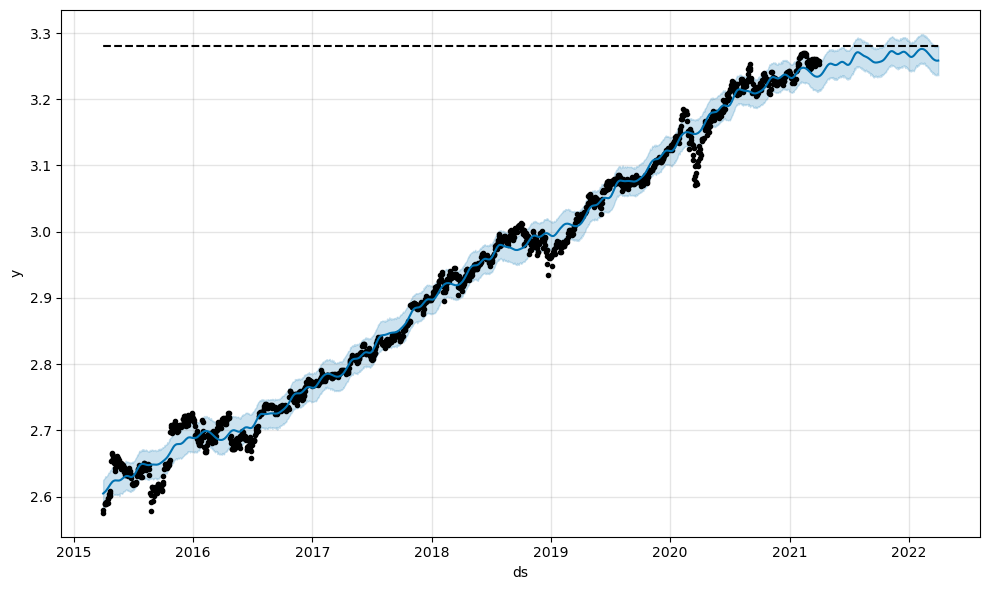

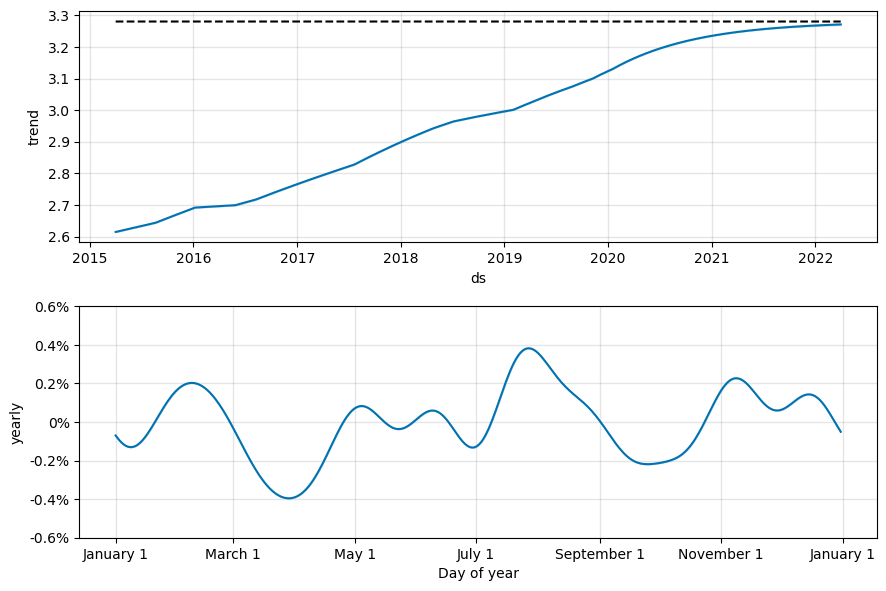

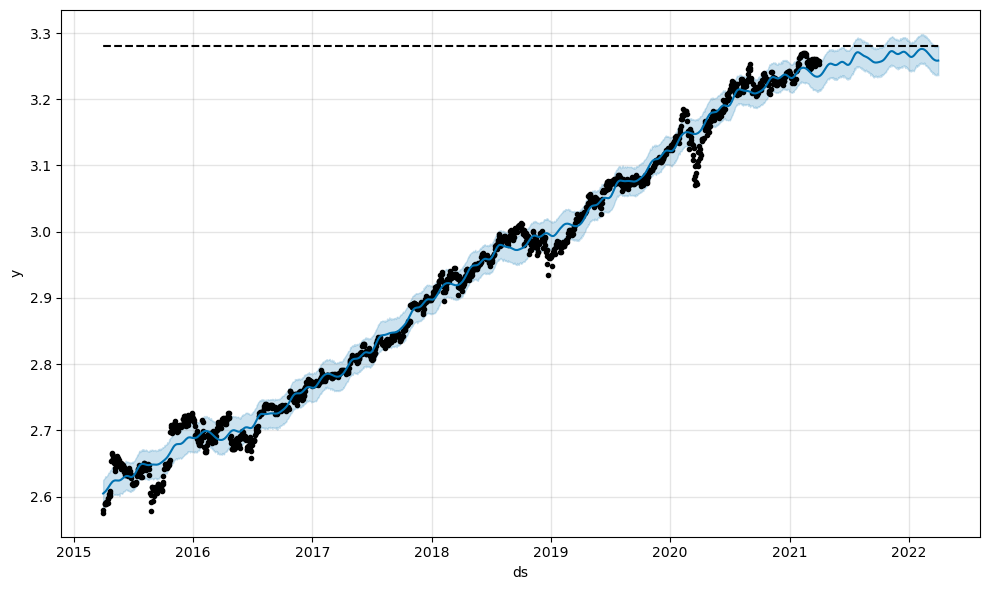

In [18]:
model.plot_components(forecast)
model.plot(forecast)

In [19]:
model = Prophet(**model_params)
model = model.add_seasonality(name = 'monthly' , period = 30 , fourier_order= 10)
model = model.add_seasonality(name = 'quarterly' , period =  92.25, fourier_order= 10)

model.add_country_holidays('US')

model.fit(data)

future = model.make_future_dataframe(periods = 365)
future['cap'] = data['cap'].max()

forecast = model.predict(future)

23:31:10 - cmdstanpy - INFO - Chain [1] start processing
23:31:15 - cmdstanpy - INFO - Chain [1] done processing


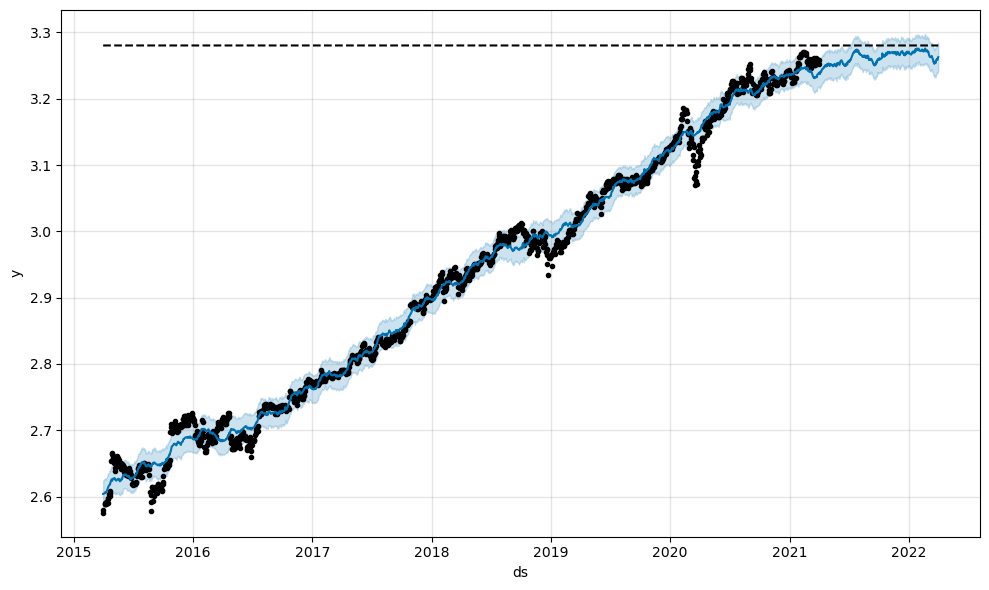

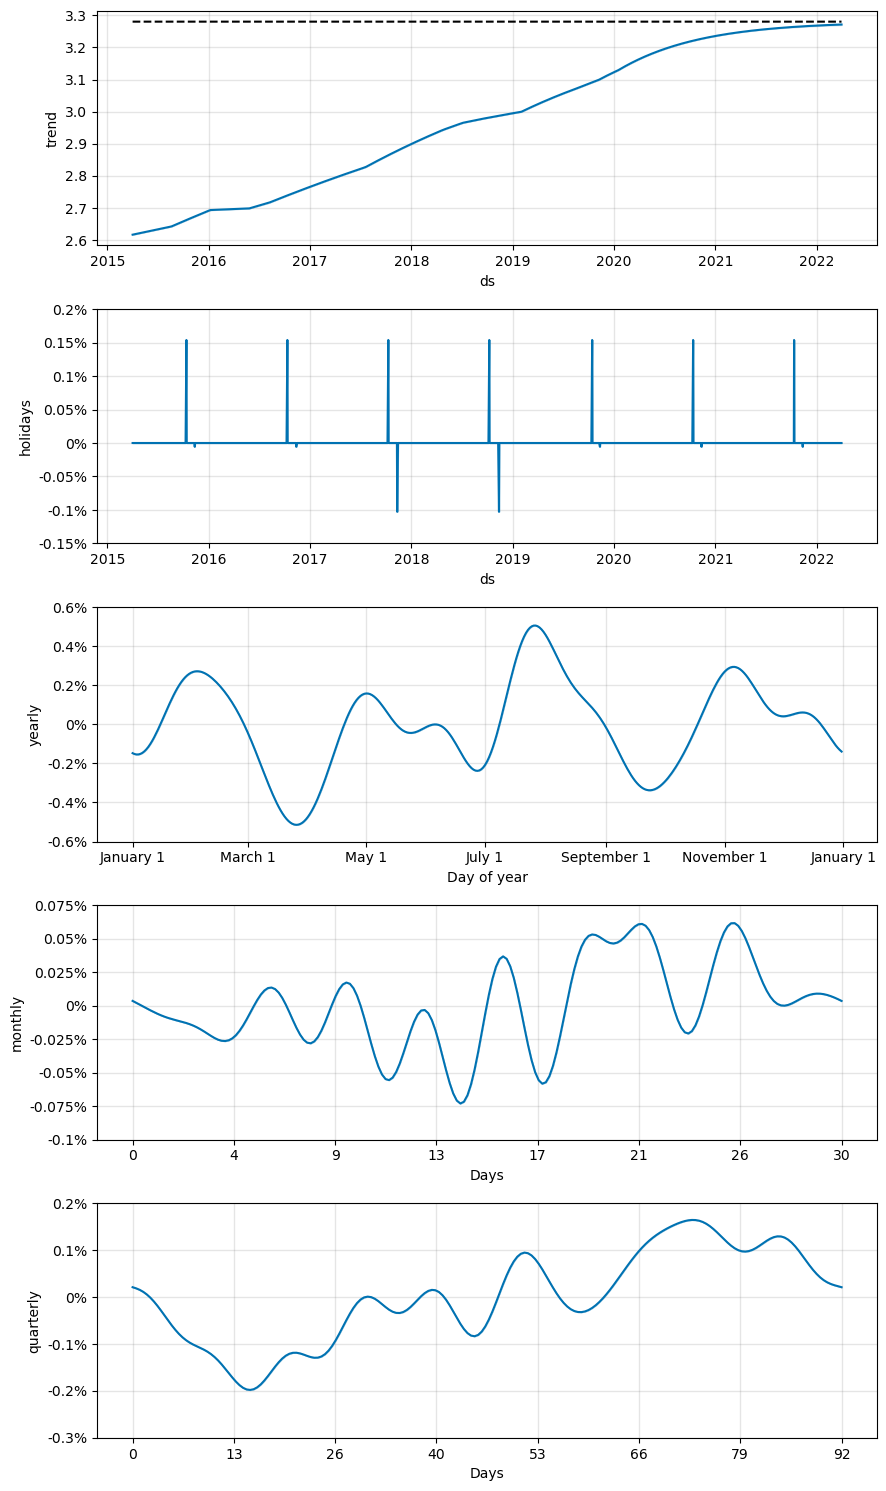

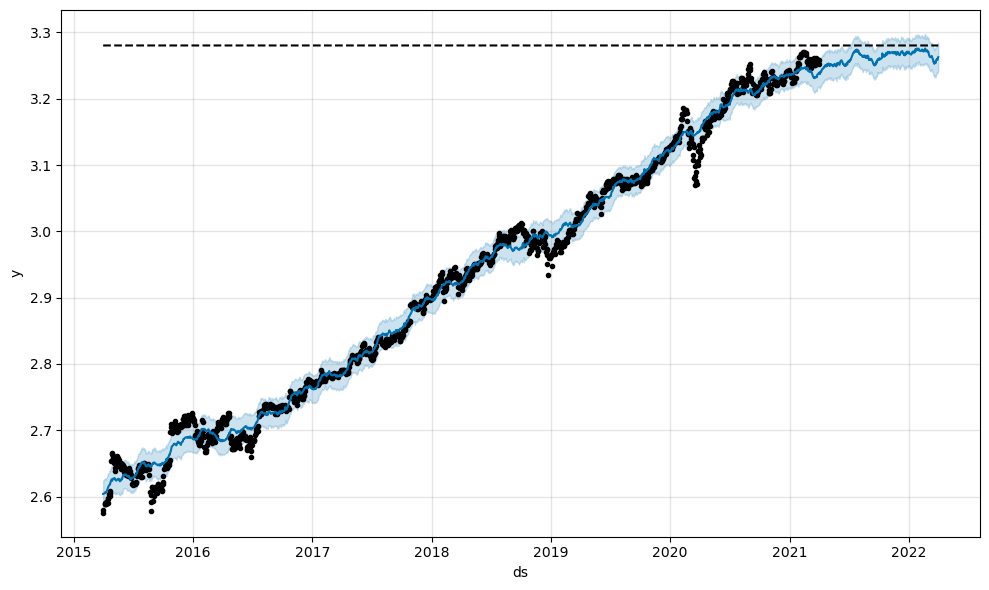

In [20]:
model.plot_components(forecast)
model.plot(forecast)

In [22]:
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

In [23]:
param_grid = {
    "daily_seasonality" : [False],
    "weekly_seasonality" : [False],
    "yearly_seasonality" : [True],
    "growth" : ['logistic'],
    'changepoint_prior_scale': [0.001,0.01,0.1,0.5],
    'seasonality_prior_scale': [0.01,0.1,0.5,10.0]

}

#generate all combiations of parameters
all_params = [
              dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())
]

print(all_params)

[{'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.5}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_p

In [24]:
rmses = list()

#go trough each combination
for params in all_params:
    m = Prophet(**params)

    m = m.add_seasonality(name = 'monthly', period = 30, fourier_order = 5)
    m = m.add_seasonality(name = 'quarterly', period = 92.25, fourier_order = 10)

    m.add_country_holidays(country_name = 'US')

    m.fit(data)

    df_cv = cross_validation(m, initial='730 days', period = '365 days', horizon = '365 days', parallel = 'processes')

    df_p = performance_metrics(df_cv, rolling_window=1)

    rmses.append(df_p['rmse'].values[0])

#find the best parameters
best_params = all_params[np.argmin(rmses)]
print("\n The best parameters are :", best_params)

23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing
23:32:32 - cmdstanpy - INFO - Chain [1] start processing
23:32:33 - cmdstanpy - INFO - Chain [1] done processing
23:32:33 - cmdstanpy - INFO - Chain [1] start processing
23:32:33 - cmdstanpy - INFO - Chain [1] start processing
23:32:33 - cmdstanpy - INFO - Chain [1] start processing
23:32:33 - cmdstanpy - INFO - Chain [1] done processing
23:32:33 - cmdstanpy - INFO - Chain [1] done processing
23:32:33 - cmdstanpy - INFO - Chain [1] done processing
23:32:37 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:46 - cmdstanpy - INFO - Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] done processing
23:32:47 - cmdstanpy - INFO - Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] done processing
23:32:47 - cmdstanpy - INFO - Chain [1]


 The best parameters are : {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


In [25]:
#foarecast with the best parameters
best_model = Prophet(**best_params)

best_model = best_model.add_seasonality(name = 'monthly', period = 30, fourier_order = 5)
best_model = best_model.add_seasonality(name = 'quarterly', period = 92.25, fourier_order = 10)

best_model.add_country_holidays(country_name = "US")

best_model.fit(data)

future = best_model.make_future_dataframe(periods=365, freq = 'D')

future['cap'] = data['cap'].max()

forecast = best_model.predict(future)

23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing


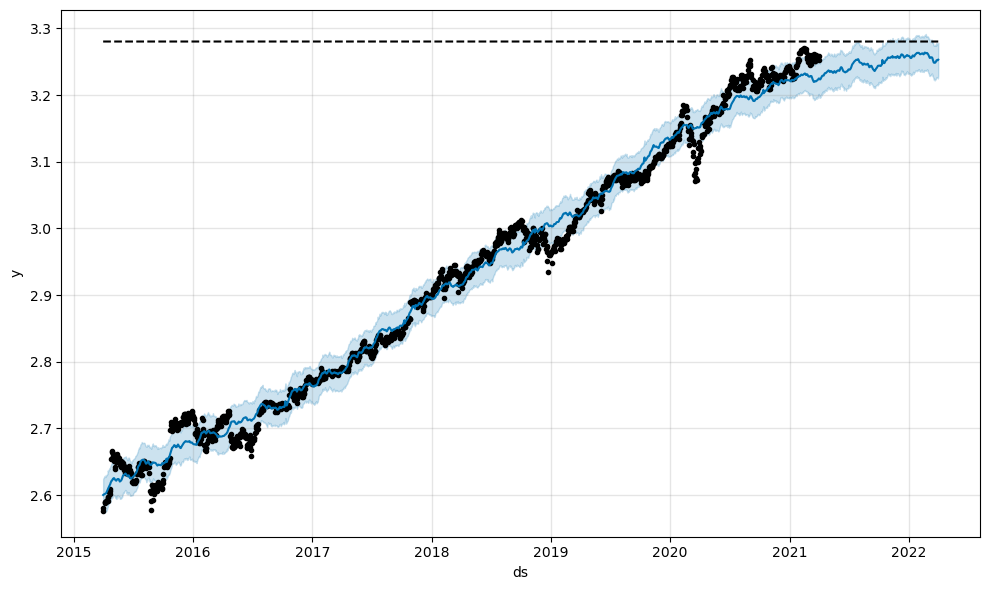

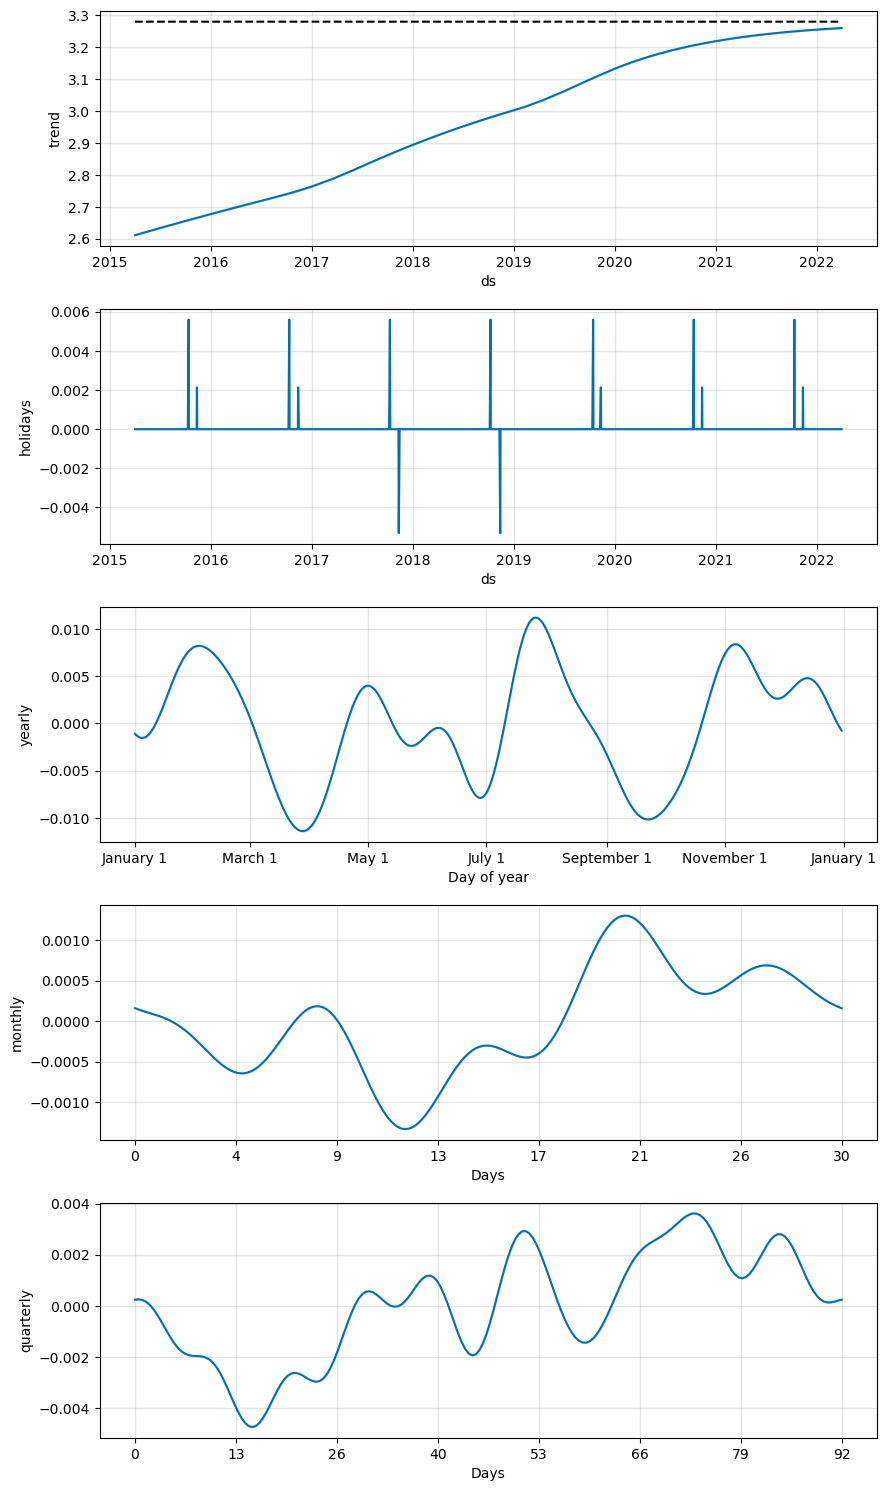

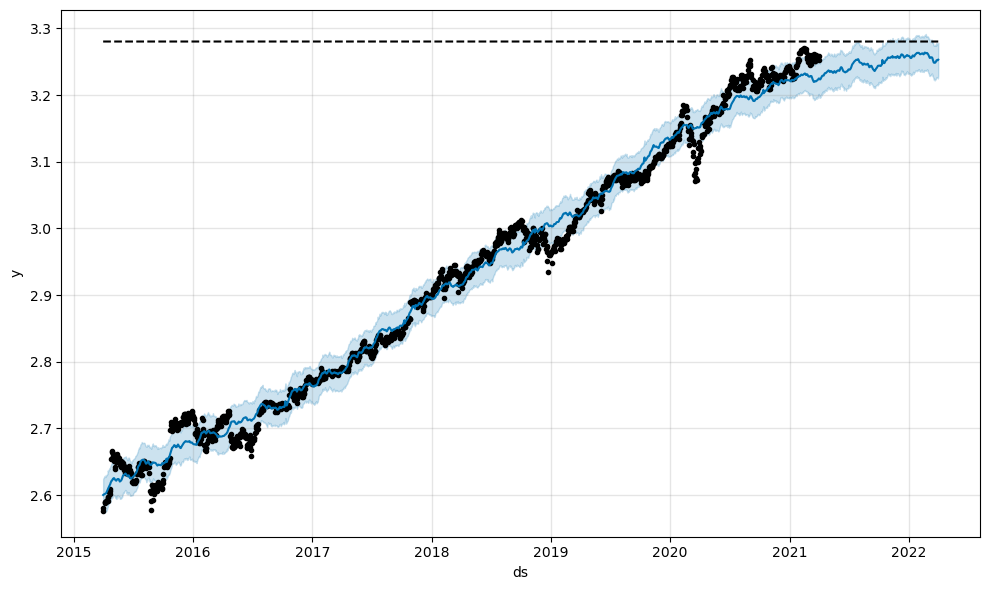

In [26]:
best_model.plot_components(forecast)
best_model.plot(forecast)

In [27]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876 entries, 0 to 1875
Data columns (total 74 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   ds                                                     1876 non-null   datetime64[ns]
 1   trend                                                  1876 non-null   float64       
 2   cap                                                    1876 non-null   float64       
 3   yhat_lower                                             1876 non-null   float64       
 4   yhat_upper                                             1876 non-null   float64       
 5   trend_lower                                            1876 non-null   float64       
 6   trend_upper                                            1876 non-null   float64       
 7   Christmas Day                                          1876 non-null 

To get the real values we need to un transform the data

<AxesSubplot:xlabel='ds'>

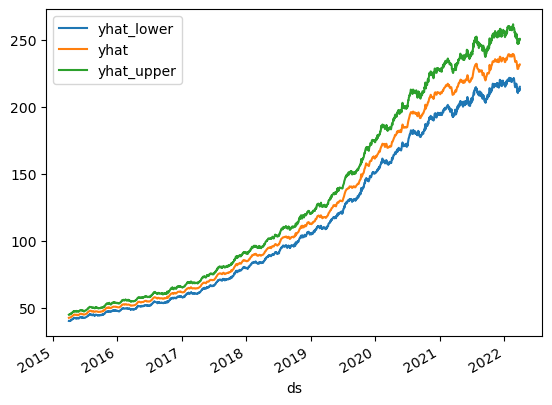

In [28]:
forecast['yhat'] = bc.untransform_boxcox(x = forecast['yhat'], lmbda = lmbda)
forecast['yhat_lower'] = bc.untransform_boxcox(x = forecast['yhat_lower'], lmbda = lmbda)
forecast['yhat_upper'] = bc.untransform_boxcox(x = forecast['yhat_upper'], lmbda = lmbda)
forecast.plot(x = 'ds', y = ['yhat_lower', 'yhat', 'yhat_upper'])
